In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Bikes 🚲

[Slides](https://docs.google.com/presentation/d/1lQ3AcIMXd1pNFiAroYExzLOLq2HGSWrJj0p8OL8vT8Q/edit#slide=id.p22)

----

The data from today is about bike sharing demand from [a previously held Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/data).  Below is a bit of documentation from the competition.

---

> You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
>
> Data Fields
> ```
> datetime - hourly date + timestamp  
> season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
> holiday - whether the day is considered a holiday
> workingday - whether the day is neither a weekend nor holiday
> weather - 1: Clear, 
>              Few clouds,
>              Partly cloudy, 
>              Partly cloudy
>           2: Mist + Cloudy, 
>              Mist + Broken clouds, 
>              Mist + Few clouds,
>              Mist
>           3: Light Snow,
>              Light Rain + Thunderstorm + Scattered clouds, 
>              Light Rain + Scattered clouds
>           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, 
>              Snow + Fog 
> temp - temperature in Celsius
> atemp - "feels like" temperature in Celsius
> humidity - relative humidity
> windspeed - wind speed
> casual - number of non-registered user rentals initiated
> registered - number of registered user rentals initiated
> count - number of total rentals
> ```

From this list of column descriptions.

* What columns are categorical?  Which of these do you think we'll need to one-hot-encode?
* Do you see any columns that you expect to be multicollinear?

In the Kaggle competition the challenge was to predict the `count` column.  The `casual` and `registered` columns aren't allowed to be used since that information is really just the `count` column broken out into its components (i.e. `count = casual + registered`).

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

### Let's do some general EDA

In [4]:
# data from https://www.kaggle.com/c/bike-sharing-demand/data
data_url = "https://docs.google.com/spreadsheets/d/1GJrx_Y3cvD1sWLg_zF_mMZZ0iZ_If2E02VIkyCi3PTc/export?format=csv"
bike_sharing = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

In [7]:
bike_sharing = bike_sharing.drop(columns=["casual", "registered"])
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,1


<IPython.core.display.Javascript object>

The column `datetime` itself isn't very useful.  Why is that and how might we get some useful info out of the column?

In [11]:
bike_sharing["datetime"] = pd.to_datetime(bike_sharing["datetime"])
bike_sharing["day_of_week"] = bike_sharing["datetime"].dt.day_name()
bike_sharing["hour"] = bike_sharing["datetime"].dt.hour


bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,day_of_week,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,Saturday,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,Saturday,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,Saturday,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,Saturday,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,Saturday,4


<IPython.core.display.Javascript object>

Drop the datetime column

In [12]:
bike_sharing = bike_sharing.drop(columns="datetime")

<IPython.core.display.Javascript object>

Investigate the column datatypes to make sure there's nothing unexpected

In [13]:
bike_sharing.dtypes

season           int64
holiday          int64
workingday       int64
weather          int64
temp           float64
atemp          float64
humidity         int64
windspeed      float64
count            int64
day_of_week     object
hour             int64
dtype: object

<IPython.core.display.Javascript object>

Do we have missing values we need to handle?

In [14]:
bike_sharing.isna().mean()

season         0.0
holiday        0.0
workingday     0.0
weather        0.0
temp           0.0
atemp          0.0
humidity       0.0
windspeed      0.0
count          0.0
day_of_week    0.0
hour           0.0
dtype: float64

<IPython.core.display.Javascript object>

Calculate summary statistics.  When doing this, pay extra attention to our response variable, `count`.

In [15]:
bike_sharing.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,23.000000


<IPython.core.display.Javascript object>

Plot a `scatter_matrix`/`pairplot` of our dataframe

In [17]:
bike_sharing.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'day_of_week', 'hour'],
      dtype='object')

<IPython.core.display.Javascript object>

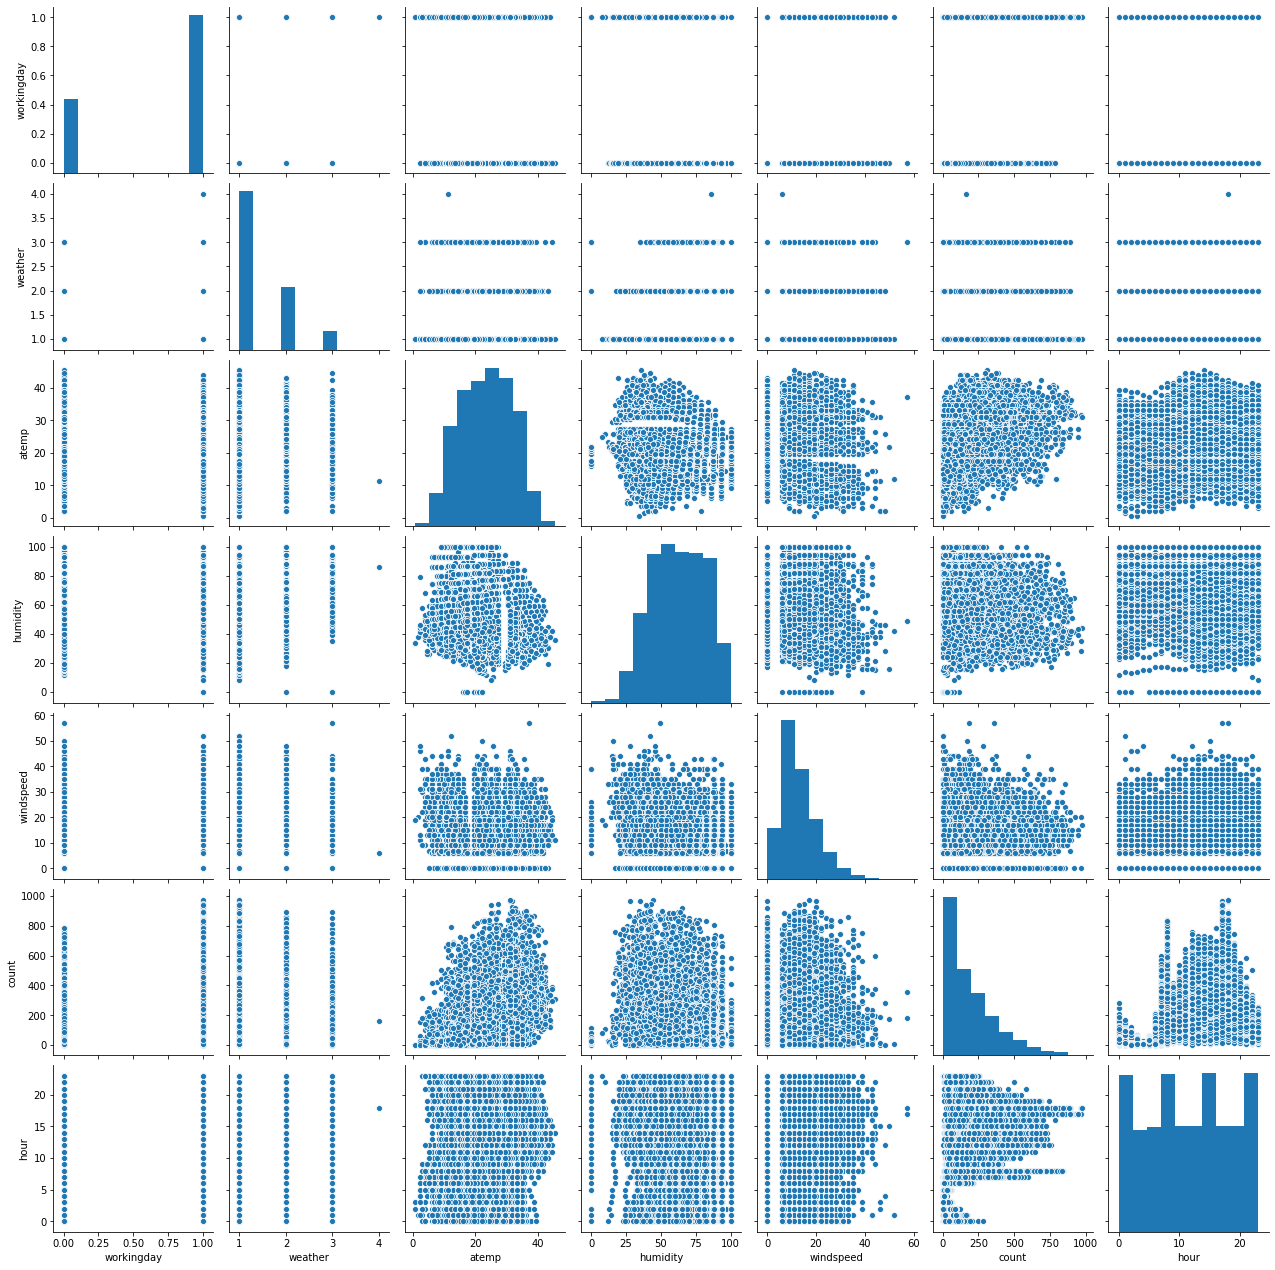

<IPython.core.display.Javascript object>

In [20]:
sns.pairplot(
    bike_sharing[
        [
            "workingday",
            "weather",
            "atemp",
            "humidity",
            "windspeed",
            "count",
            "day_of_week",
            "hour",
        ]
    ]
)

In [24]:
bike_sharing["day_of_week"].value_counts()

Saturday     1584
Sunday       1579
Thursday     1553
Monday       1551
Wednesday    1551
Tuesday      1539
Friday       1529
Name: day_of_week, dtype: int64

<IPython.core.display.Javascript object>

Some things to point out.

* Its not the strongest thing, but, temperature seems to have an effect on rentals (the higher the temp the more rentals).  This effect seems more prominent in the casual rentals.
* Both humidity and windspeed seem to have negative effects.  When they're low, there doesn't seem to be a big correlation, but when these factors are high we see a drop off in rentals.
* We won't be using this information, but note the plots between casual & count.  We see a pretty distinct v-shape, this is indicative of an interaction happening somewhere.  That is, there seems to be 2 distinct groups of data, we could try and explore and find a reason for this split.
* Our response variable `count` is a very positively skewed distribution.  This indicates that we might want to perform a transformation to it.  For now we'll leave it, and come back to this.

Plot the distribution of the response

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

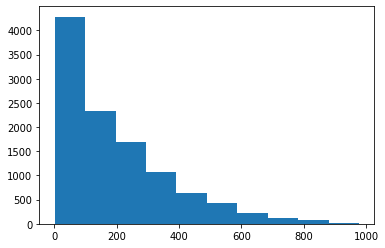

<IPython.core.display.Javascript object>

In [23]:
plt.hist(bike_sharing["count"])

The boxplot of our response variable also shows some outliers we might want to deal with.  This is something we might come back to.

## Prep data for modeling

One-hot encode features where appropriate

In [51]:
X = bike_sharing.drop(columns=["count", "temp", "workingday"])
y = bike_sharing["count"]

<IPython.core.display.Javascript object>

In [39]:
bike_sharing.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'day_of_week', 'hour'],
      dtype='object')

<IPython.core.display.Javascript object>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [54]:
cat_cols = ["day_of_week"]
drop_cats = ["Saturday"]

num_cols = [
    "season",
    "weather",
    "atemp",
    "humidity",
    "windspeed",
    "hour",
]
bin_cols = ["holiday"]

ct = ColumnTransformer(
    #   Format
    #   [("name of step", WhatToDo(), list_of_columns_to_do_it_to)]
    [
        ("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    # What should we do to the rest of the data?
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [55]:
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

<IPython.core.display.Javascript object>

In [56]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)
new_col_names = cat_names + num_cols + bin_cols

X_train = pd.DataFrame(X_train_trans, index=X_train.index, columns=new_col_names)
X_test = pd.DataFrame(X_test_trans, index=X_test.index, columns=new_col_names)

X_train.head(2)

,day_of_week_Friday,day_of_week_Monday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,season,weather,atemp,humidity,windspeed,hour,holiday
2815,0.0,0.0,0.0,0.0,0.0,1.0,0.441439,-0.657286,0.960505,1.098553,-0.828356,-0.945962,0.0
8695,0.0,0.0,0.0,0.0,0.0,0.0,0.441439,-0.657286,2.034991,-1.182694,0.878555,0.643217,0.0


<IPython.core.display.Javascript object>

Separate data into its `X` and `y` components, and perform a `train_test_split`

In [57]:
print_vif(X_train)

VIF results
-------------------------------
const                    6.889740
day_of_week_Friday       1.704889
day_of_week_Monday       1.810844
day_of_week_Sunday       1.709474
day_of_week_Thursday     1.705865
day_of_week_Tuesday      1.704112
day_of_week_Wednesday    1.705950
season                   1.136819
weather                  1.253638
atemp                    1.110738
humidity                 1.531365
windspeed                1.155303
hour                     1.120546
holiday                  1.112268
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Assess multicollinearity with variance inflation factor.

Address any issues with collinearity

## Build a ridge regression model

Build a plain ole `LinearRegression` model for comparison

In [58]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

In [59]:
lm.score(X_train, y_train)

0.3345806384201112

<IPython.core.display.Javascript object>

In [60]:
lm.score(X_test, y_test)

0.3414191995975253

<IPython.core.display.Javascript object>

Build a fancy ole Ridge regression model

In [67]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

<IPython.core.display.Javascript object>

In [68]:
ridge.score(X_train, y_train)

0.33458062346844364

<IPython.core.display.Javascript object>

In [66]:
ridge.score(X_test, y_test)

0.3389628042346843

<IPython.core.display.Javascript object>

No real change in our $R^2$ here.. whats the deal man? I thought this was used to make things better.  Remember what the loss function is doing.  We're including a penalty for large coefficients, so let's see how they changed.

In [71]:
lm.coef_

array([ -2.88783272,  -9.02267025, -17.04987743,  -9.44013009,
       -11.30515883,  -6.56204887,  24.46832658,  -2.02507297,
        54.22035596, -42.83290302,   3.13089874,  53.11956502,
       -12.08247695])

<IPython.core.display.Javascript object>

In [70]:
ridge.coef_

array([ -2.8426845 ,  -8.97814789, -16.9923925 ,  -9.3875221 ,
       -11.25118428,  -6.51318421,  24.4655286 ,  -2.02740945,
        54.21533595, -42.82802241,   3.13190261,  53.11514942,
       -12.03554148])

<IPython.core.display.Javascript object>

Let's actually see numbers other than $R^2$.  How are our predictions?

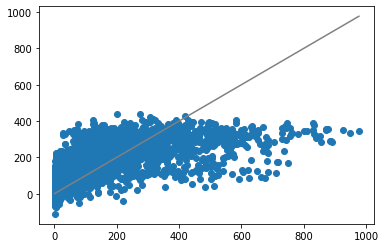

<IPython.core.display.Javascript object>

In [73]:
y_pred = lm.predict(X_test)

mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")

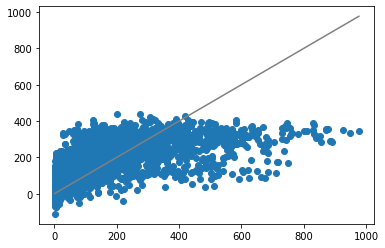

<IPython.core.display.Javascript object>

In [72]:
y_pred = ridge.predict(X_test)

mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")

We want to fall evenly around that line.  Right now, we're underpredicting high values.  In our EDA we made a comment about our response's skewed distribution.  We might want to reconsider a transformation.  A log transformation is a good one to start with for right skewed data.

Refit the model on a logged version of `y`.

In [74]:
ridge = Ridge()
ridge.fit(X_train, np.log(y_train))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

<IPython.core.display.Javascript object>

In [76]:
ridge.score(X_train, np.log(y_train))

0.4577116851407521

<IPython.core.display.Javascript object>

In [77]:
ridge.score(X_test, np.log(y_test))

0.46481684179038646

<IPython.core.display.Javascript object>

Re-evaluate the predictions

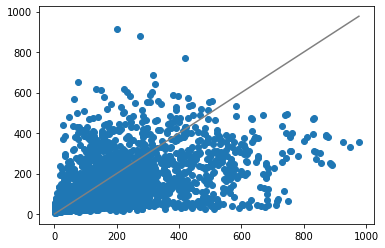

<IPython.core.display.Javascript object>

In [75]:
y_pred = ridge.predict(X_test)
y_pred = np.exp(y_pred)
mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")

## Build a LASSO regression model 🤠

In [78]:
lasso = Lasso()
lasso.fit(X_train, np.log(y_train))

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<IPython.core.display.Javascript object>

How are our coefficients looking now?

In [ ]:
lasso.coef_

Well... the coefficient shrinking definitely did its thing here... We probably want a better way of selecting an alpha than guess and check.  This is where cross validation comes into play paired with something called a gridsearch.  All the grid search does is find the best combination of hyperparameters that we tell it to test.  Here our only hyperparameter will be alpha.

Let's fit lasso using a gridsearch for the best alpha.  After we fit the model lets view the best alpha and the new coefficients.

In [82]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1)
lasso_cv.fit(X_train, np.log(y_train))

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
selected alpha: 0.001


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


array([ 0.01363129, -0.10690454, -0.05364429, -0.12345257, -0.16693162,
       -0.12377135,  0.20576197,  0.        ,  0.37625457, -0.30930691,
        0.02123045,  0.70478584, -0.02309257])

<IPython.core.display.Javascript object>

In [84]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, np.log(y_train))

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<IPython.core.display.Javascript object>

In [85]:
lasso.score(X_train, np.log(y_train))

0.45762645568729987

<IPython.core.display.Javascript object>

In [86]:
lasso.score(X_test, np.log(y_test))

0.46498672611940967

<IPython.core.display.Javascript object>

Evaluate the predictions

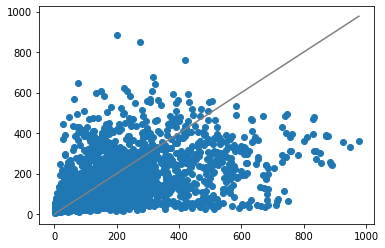

<IPython.core.display.Javascript object>

In [87]:
y_pred = lasso.predict(X_test)
y_pred = np.exp(y_pred)
mn = y_test.min()
mx = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([mn, mx], [mn, mx], c="gray")

We're now on par with the ridge regression results.  Not the most fair comparison though, with ridge regression we didn't grid search, we just made up a value for alpha.  On your own you can implement grid search for the ridge regression and see how/if the results improve.

## Build an elasticnet regression model

In [89]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0, 0.25, 0.5, 0.75, 1.0]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, np.log(y_train))

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4152.828231434986, tolerance: 1.5447556299911795
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4162.720832799261, tolerance: 1.5277628395994511
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4175.815803332271, tolerance: 1.5565837214567744
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Object

selected alpha: 0.01
selected l1_ratio: 0


array([ 0.02682975, -0.09632788, -0.04999417, -0.11504657, -0.15564639,
       -0.1150654 ,  0.20513721, -0.00098478,  0.3744749 , -0.3077578 ,
        0.02318364,  0.69913308, -0.0454801 ])

<IPython.core.display.Javascript object>

The `l1_ratio` selected was 1.0... what does this mean?  (the answer to this question is also the reason why there's no analysis on the model results)